# **Segmentação de Clientes de E-commerce para Otimização de Marketing através de Clusterização**

## Visão Geral
O [Online Retail](https://archive.ics.uci.edu/ml/datasets/online+retail) é um conjunto de dados transnacional que contém todas as transações realizadas entre 01/12/2010 e 09/12/2011 em uma loja online registrada no Reino Unido. A empresa se dedica principalmente à venda de presentes exclusivos para diversas ocasiões. Muitos de seus clientes são atacadistas.

## Objetivo de Negócio
Nosso objetivo é segmentar os clientes com base no modelo **RFM** (Recência, Frequência e Valor), para que a empresa possa direcionar suas campanhas de marketing de maneira mais eficaz e personalizada.



## 1. Carregamento e Visualização dos Dados


In [48]:

# Bibliotecas para manipulação de dados
import numpy as np
import pandas as pd
import datetime as dt

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para pré-processamento de dados e clusterização
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Bibliotecas para análise de cluster hierárquico
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [49]:
# Carregar o dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

In [50]:
# Exibindo as primeiras linhas para inspeção
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 2. Limpeza e Tranformação dos Dados

In [51]:
# Limpeza dos dados
df.dropna(subset=['CustomerID'], inplace=True)  # Remover clientes sem ID
df = df[df['Quantity'] > 0]  # Remover transações com quantidade negativa


In [52]:
# Alterando o tipo de dado do ID do Cliente de acordo com a lógica de negócio
df['CustomerID'] = df['CustomerID'].astype(str)

Agora iremos criar novos atributos:

* Receita (M): Receita total gerada pelas transações
* Transações (F): Total de transações realizadas
* Recência (R): Quantidade de dias desde a última compra




In [53]:
# Receita
df['Receita'] = df['Quantity']*df['UnitPrice']
rfm_m = df.groupby('CustomerID')['Receita'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Receita
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [63]:
# Transações

rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Transacoes']
rfm_f.head()

,CustomerID,Transacoes
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [64]:
# Mergiando os dois DF

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Receita,Transacoes
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [65]:
# Recência

# Conversão do Dataset para o formato de data que vamos precisar

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [66]:
# Calcular a data máxima para identificar a última data de transação

max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [67]:
# Calculando a diferença entre a data máxima e a data da transação.

df['Diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Receita,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [68]:
# Calculando a recencia por usuário

rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [69]:
# Extraindo apenas o número de dias.

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [70]:
# Mergiando os DF

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Receita', 'Transacoes', 'Recencia']
rfm.head()

,CustomerID,Receita,Transacoes,Recencia
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


## Remoção de Outliers

Text(0.5, 0, 'Atributos')

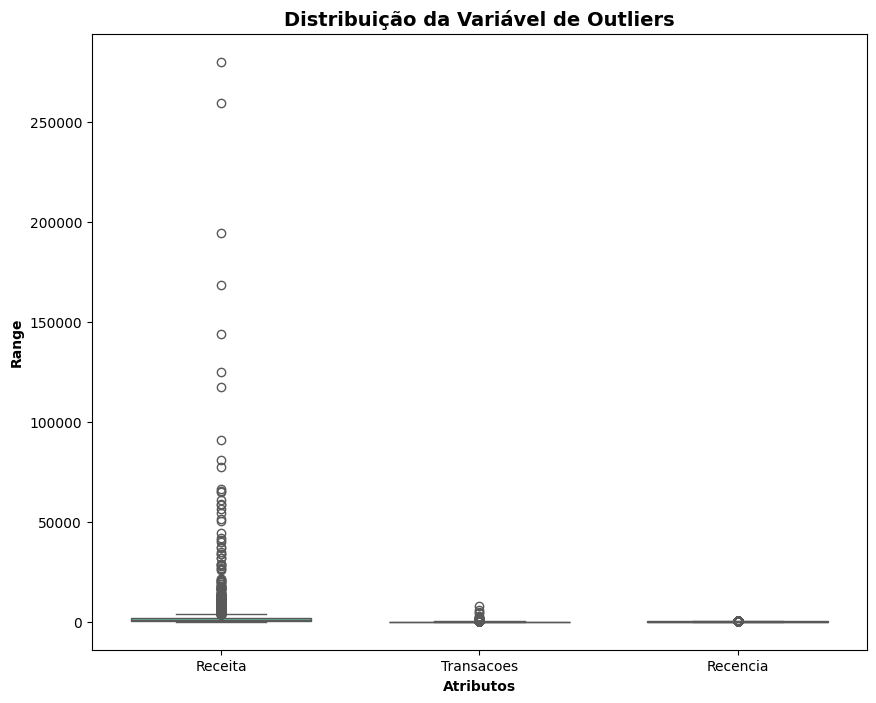

In [71]:
# Análise de Outliers de Receita, Frequência e Recência

attributes = ['Receita','Transacoes','Recencia']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribuição da Variável de Outliers", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Atributos", fontweight = 'bold')

In [72]:
# Removendo outliers (estatísticos) Receita
Q1 = rfm.Receita.quantile(0.05)
Q3 = rfm.Receita.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Receita >= Q1 - 1.5*IQR) & (rfm.Receita <= Q3 + 1.5*IQR)]

# Removendo outliers (estatísticos) Regência
Q1 = rfm.Recencia.quantile(0.05)
Q3 = rfm.Recencia.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recencia >= Q1 - 1.5*IQR) & (rfm.Recencia <= Q3 + 1.5*IQR)]

# Removendo outliers (estatísticos) Transações
Q1 = rfm.Transacoes.quantile(0.05)
Q3 = rfm.Transacoes.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Transacoes >= Q1 - 1.5*IQR) & (rfm.Transacoes <= Q3 + 1.5*IQR)]

### Padronização dos Dados

In [76]:
# Padronizando os dados (colocando eles em escala comparável)
rfm_df = rfm[['Receita', 'Transacoes', 'Recencia']]
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4257, 3)

In [77]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Receita', 'Transacoes', 'Recencia']
rfm_df_scaled.head()

,Receita,Transacoes,Recencia
0,1.645726,1.067832,-0.917872
1,0.262124,-0.460601,-0.189272
2,0.240269,-0.035474,-0.748198
3,-0.543361,-0.602310,2.156221
4,0.652411,0.085991,-0.578524


# Treinando o Modelo

### K-Means

In [78]:
# k-means com número arbitrário de clusters

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [79]:
kmeans.labels_

array([3, 0, 0, ..., 2, 0, 0], dtype=int32)

### Encontrando o número ideal de clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

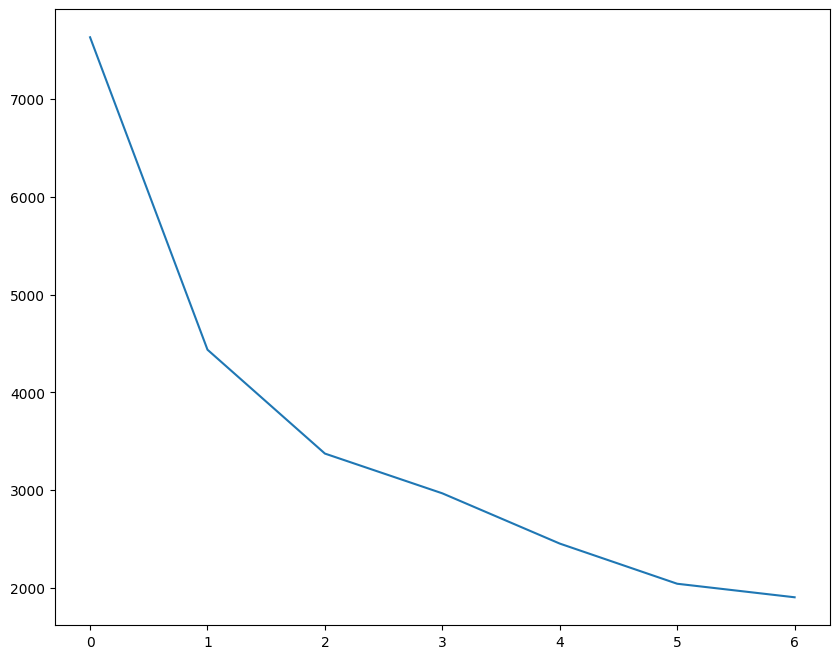

In [80]:
# Método Elbow Curve

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# plot
plt.plot(ssd)

In [81]:
# Silhouette Score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))



For n_clusters=2, the silhouette score is 0.540625413768531
For n_clusters=3, the silhouette score is 0.5087756865796796
For n_clusters=4, the silhouette score is 0.4851654323063987
For n_clusters=5, the silhouette score is 0.4126773944799963
For n_clusters=6, the silhouette score is 0.45211690649990066
For n_clusters=7, the silhouette score is 0.4159367819614091
For n_clusters=8, the silhouette score is 0.38399245217635086


In [84]:
# O número de clusters que separa melhor estes dados é k=2
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=2)

In [85]:
 kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0], dtype=int32)

In [86]:
# rotulando
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Receita,Transacoes,Recencia,Cluster_Id
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0
5,12352.0,2506.04,85,35,0


<Axes: xlabel='Cluster_Id', ylabel='Receita'>

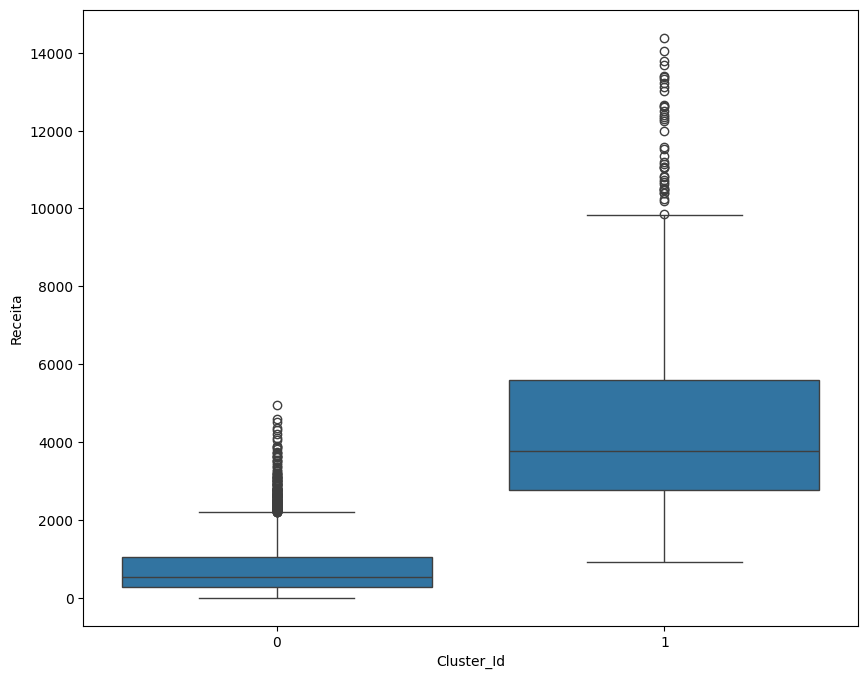

In [88]:
# Box plot para visualizar Cluster Id vs Receita

sns.boxplot(x='Cluster_Id', y='Receita', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Transacoes'>

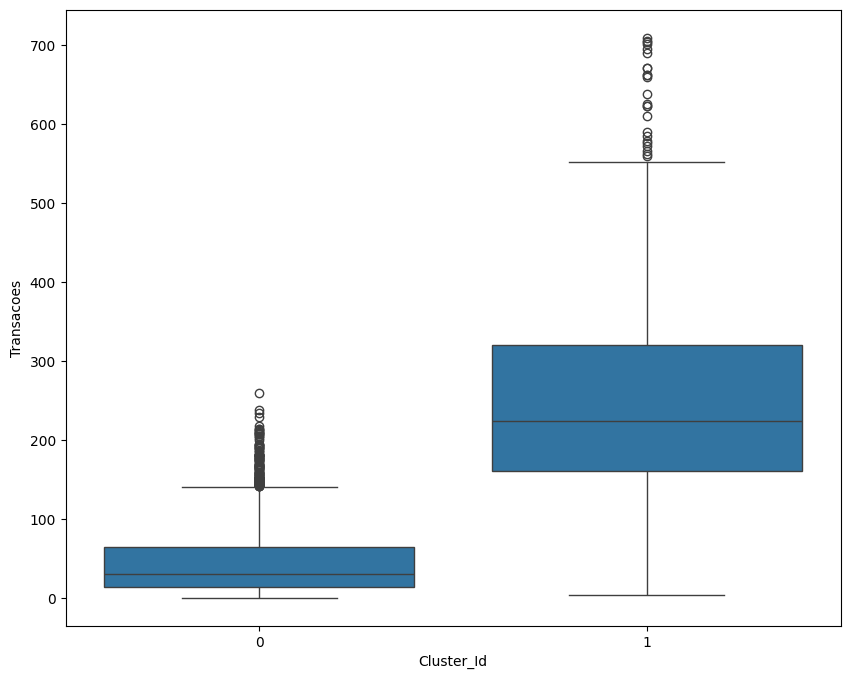

In [90]:
# Box plot para visualizar Cluster Id vs Transações

sns.boxplot(x='Cluster_Id', y='Transacoes', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recencia'>

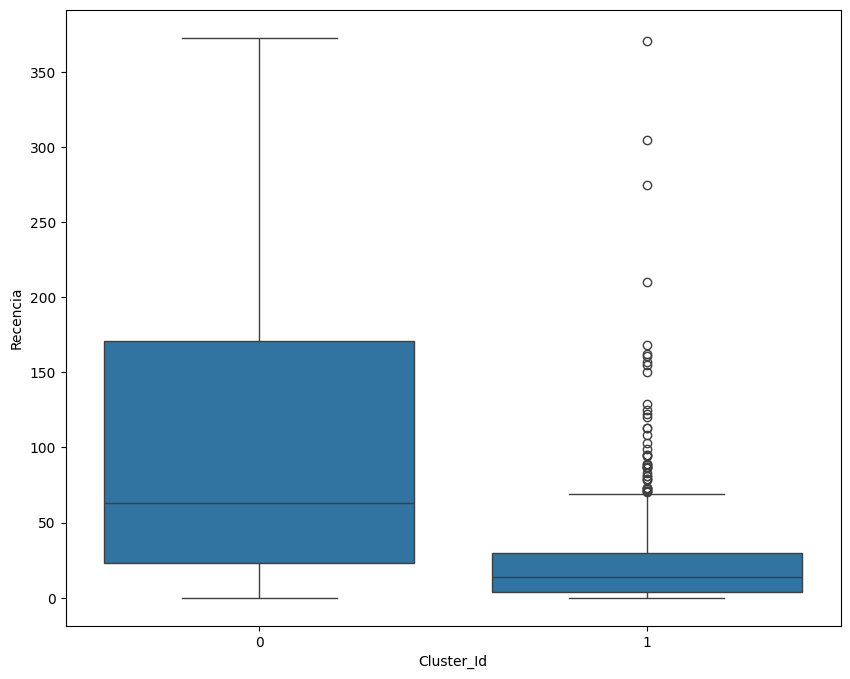

In [91]:
# Box plot para visualizar Cluster Id vs Recencia

sns.boxplot(x='Cluster_Id', y='Recencia', data=rfm)

# 5. Resultado da Análise

### Inferência:
K-Means Clustering com 2 clusterizações:
* Usuários classificados com ID 1 são:
** Compradodores com mais regularidade de compras (a recencia é baixa)
** Compradodores com maior volume de compras (o número de transações é mais alto)
** Compradodores que geram mais receita

Portanto, o público alvo das ações de marketing deve ser para este público.